In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [3]:
data = pd.read_csv('creditcard_data.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284806, 31)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284806 entries, 0 to 284805
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284806 non-null  float64
 1   V1      284806 non-null  float64
 2   V2      284806 non-null  float64
 3   V3      284806 non-null  float64
 4   V4      284806 non-null  float64
 5   V5      284806 non-null  float64
 6   V6      284806 non-null  float64
 7   V7      284806 non-null  float64
 8   V8      284806 non-null  float64
 9   V9      284806 non-null  float64
 10  V10     284806 non-null  float64
 11  V11     284806 non-null  float64
 12  V12     284806 non-null  float64
 13  V13     284806 non-null  float64
 14  V14     284806 non-null  float64
 15  V15     284806 non-null  float64
 16  V16     284806 non-null  float64
 17  V17     284806 non-null  float64
 18  V18     284806 non-null  float64
 19  V19     284806 non-null  float64
 20  V20     284806 non-null  float64
 21  V21     28

# Exploratory Data Analysis

In [6]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

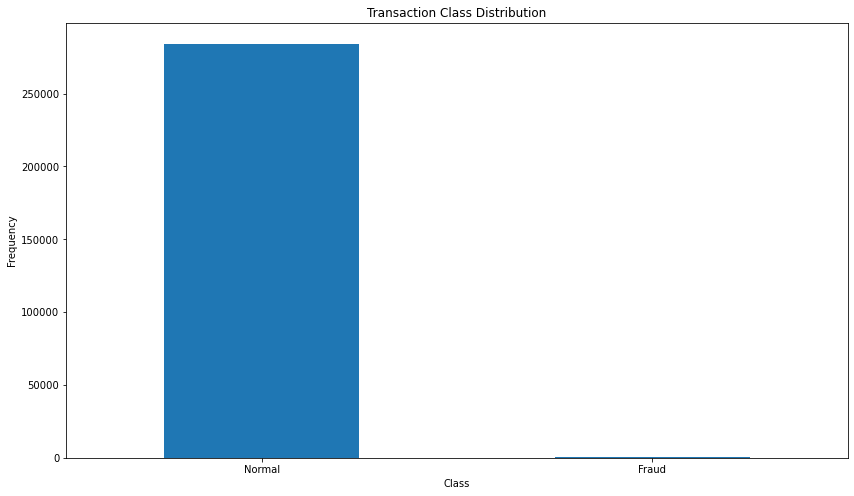

In [7]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [9]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

print(fraud.shape,normal.shape)

(492, 31) (284314, 31)


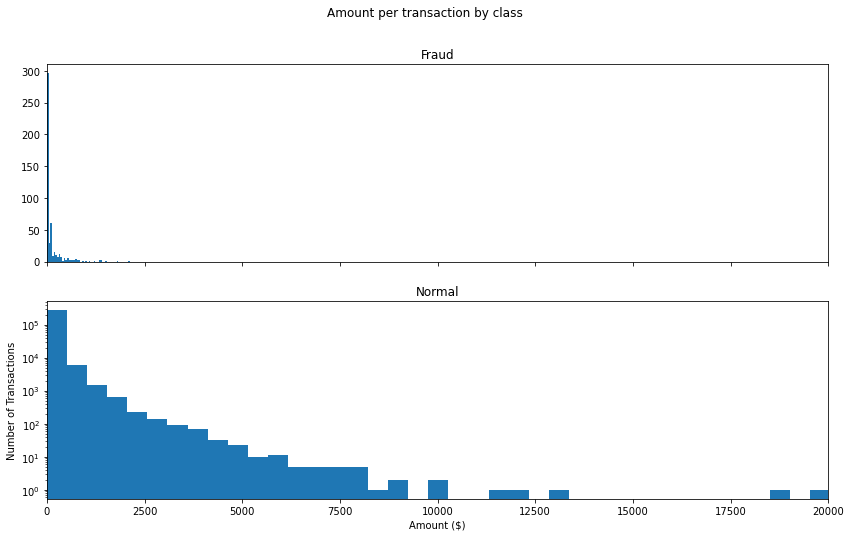

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

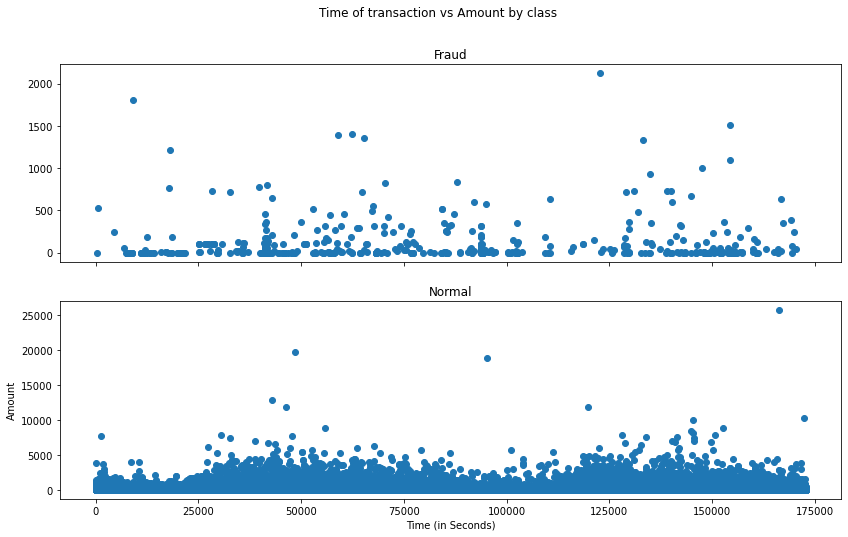

In [14]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [15]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [16]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [17]:

print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))


0.0016529506928325245
Fraud Cases : 47
Valid Cases : 28434


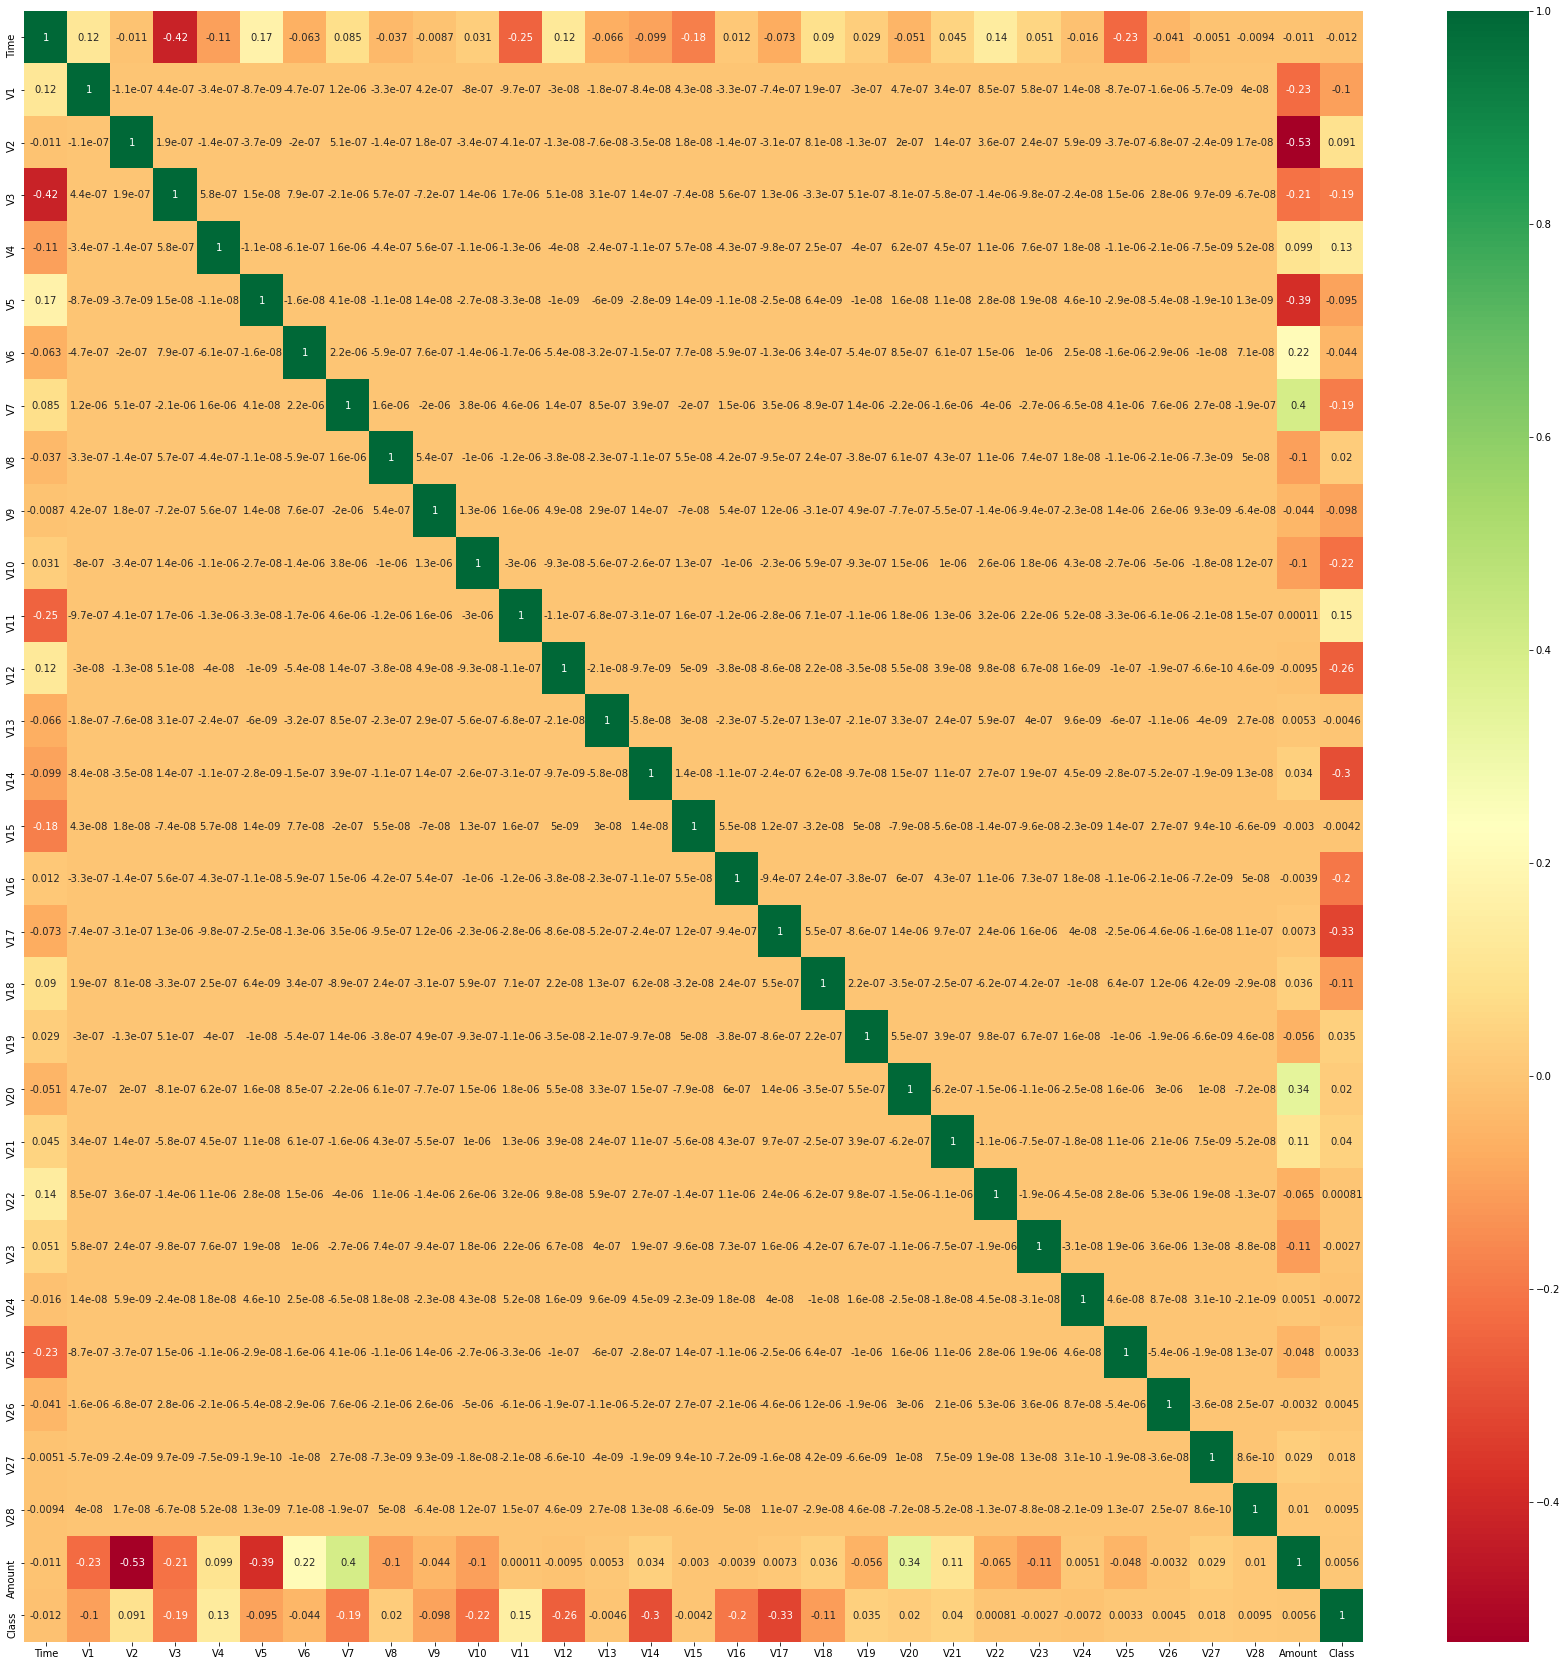

In [20]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [23]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
print(columns)
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

print(X_outliers)

print(X.shape)
print(Y.shape)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
[[0.37454012 0.95071431 0.73199394 ... 0.51423444 0.59241457 0.04645041]
 [0.60754485 0.17052412 0.06505159 ... 0.19598286 0.04522729 0.32533033]
 [0.38867729 0.27134903 0.82873751 ... 0.63755747 0.88721274 0.47221493]
 ...
 [0.9759548  0.00835751 0.39654879 ... 0.27124459 0.49869169 0.0681891 ]
 [0.36655003 0.30495987 0.25223322 ... 0.42485128 0.20312083 0.42905276]
 [0.97759176 0.38214378 0.07343188 ... 0.04355135 0.6165196  0.17670918]]
(28481, 30)
(28481,)


In [28]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [29]:
type(classifiers)

dict

In [30]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 67
Accuracy Score :
0.9976475545100242
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28434
           1       0.29      0.30      0.29        47

    accuracy                           1.00     28481
   macro avg       0.65      0.65      0.65     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 93
Accuracy Score :
0.9967346652154068
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28434
           1       0.02      0.02      0.02        47

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8412
Accuracy Score :
0.7046452020645343
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.71   

#### Observations :
- Isolation Forest detected 67 errors versus Local Outlier Factor detecting 93 errors vs. SVM detecting 8412 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases